In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import DualwormFunctions as dw
import Observables as obs
%load_ext line_profiler
%load_ext memory_profiler
import RunBasis
import argparse
import StartStates as strst
import numpy as np
import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nst =2048;
nsm = 32;
nips = 20;
nb = 8;
measperiod = 1;
J1 = 1
J2 = 0.3
J3 = 0.1
loadfromfile = True
filename = "testGS"
checkgs = False
checkgsid = 0

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = 4, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling')
    parser.add_argument('--h', type = float, default = 0.0,
                        help = 'Magnetic field')
    
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = 4,
                        help = 'number of threads to use')

    #INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with the maximally magnetised GS''')
    parser.add_argument('--loadfromfile', default = loadfromfile, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = filename, 
                        help = '''name of the previously performed simulation''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = 10,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = 0.1, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--alternate', default = False, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = checkgs, action = 'store_true',
                        help = 'check wether the simulation reaches the expected ground state')
    parser.add_argument('--checkgsid', type = int, default = checkgsid,
                        help = 'index of the ground state phase to check')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.001, 10],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [32],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    
    #CORRELATIONS PARAMETER
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = False, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--magnstats', default = False, action = 'store_true', 
                       help = 'activate if you want to compute the magnetisation statistics')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = False, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = "testGS", help = 'saving filename (.pkl will be added)')
    args = parser.parse_args()
    return args

In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
meanstat, failedupdatesth, failedupdates = callRunBasis()
print("Everything seems to be running smoothly")

-------------------Initialisation--------------------
Lattice side size:  4
J1  1
J2  0.3
J3  0.1
J3st  0.1
h 0.0
Couplings exacted
dw.Hamiltonian done
hamiltonian computed
0 32
Number of temperatures:  32
Initialisation: load from file
List of measurements to be performed: ['Energy']
List of temperature indices to measure: range(0, 32)
-----------Thermalisation------------------
Number of thermalisation steps =  2048
itermcs =  2048
magnstats False
statsfunctions []
h =  0.0
Time for mcsevolve = 0.03217240911908448
Time for tempering = 0.0013110474683344364
Time for mapping to spins + computing statistics= 5.742884241044521e-06
Time for all thermalisation steps =  68.59152245521545
-----------Measurements-----------------
Number of measurement steps =  32
['Energy']
Measurement period: 1
itermcs =  32
magnstats False
statsfunctions [<function energy at 0x7f9a293aae18>]
h =  0.0
Time for mcsevolve = 0.03699258714914322
Time for tempering = 0.001472756266593933
Time for mapping to spins

In [7]:
# Create a folder to save the pictures
foldername = ''
results_foldername = 'Results/'
os.makedirs('./' + foldername + 'Plots' + results_foldername, exist_ok = True)

filenamelist = ['testGS']
n = len(filenamelist)

In [8]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt, stat_temps, 
 temperatures_plots, listfunctions, sref] = af.LoadParameters(foldername, filenamelist)

In [9]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_MeanE, t_MeanEsq, t_varMeanE, t_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites, nb,
               stat_temps, temperatures, listfunctions, **kw)

In [10]:
print(t_MeanE[0])
print(-2/3*J1[0] -2/3*J2[0] + J3[0])

[-0.76666667 -0.76666667 -0.76666667 -0.76388889 -0.76388889 -0.76388889
 -0.76388889 -0.76388889 -0.76388889 -0.76388889 -0.76111111 -0.76111111
 -0.76111111 -0.76111111 -0.7609375  -0.76059028 -0.75833333 -0.75598958
 -0.72864583 -0.72274306 -0.69826389 -0.67586806 -0.65451389 -0.62369792
 -0.58506944 -0.53472222 -0.47152778 -0.36736111 -0.3234375  -0.259375
 -0.22230903 -0.19583333]
-0.7666666666666666


Verifying that the low temperatures of file  testGS correspond to the ground state.
Phase 1:  True
Phase 2:  False
Phase 3:  False
Phase 4:  False
Phase 5:  False
Phase 6:  False
Phase 7:  False
Phase 8:  False
Phase 9:  False
Phase 10:  False
Phase 11:  False


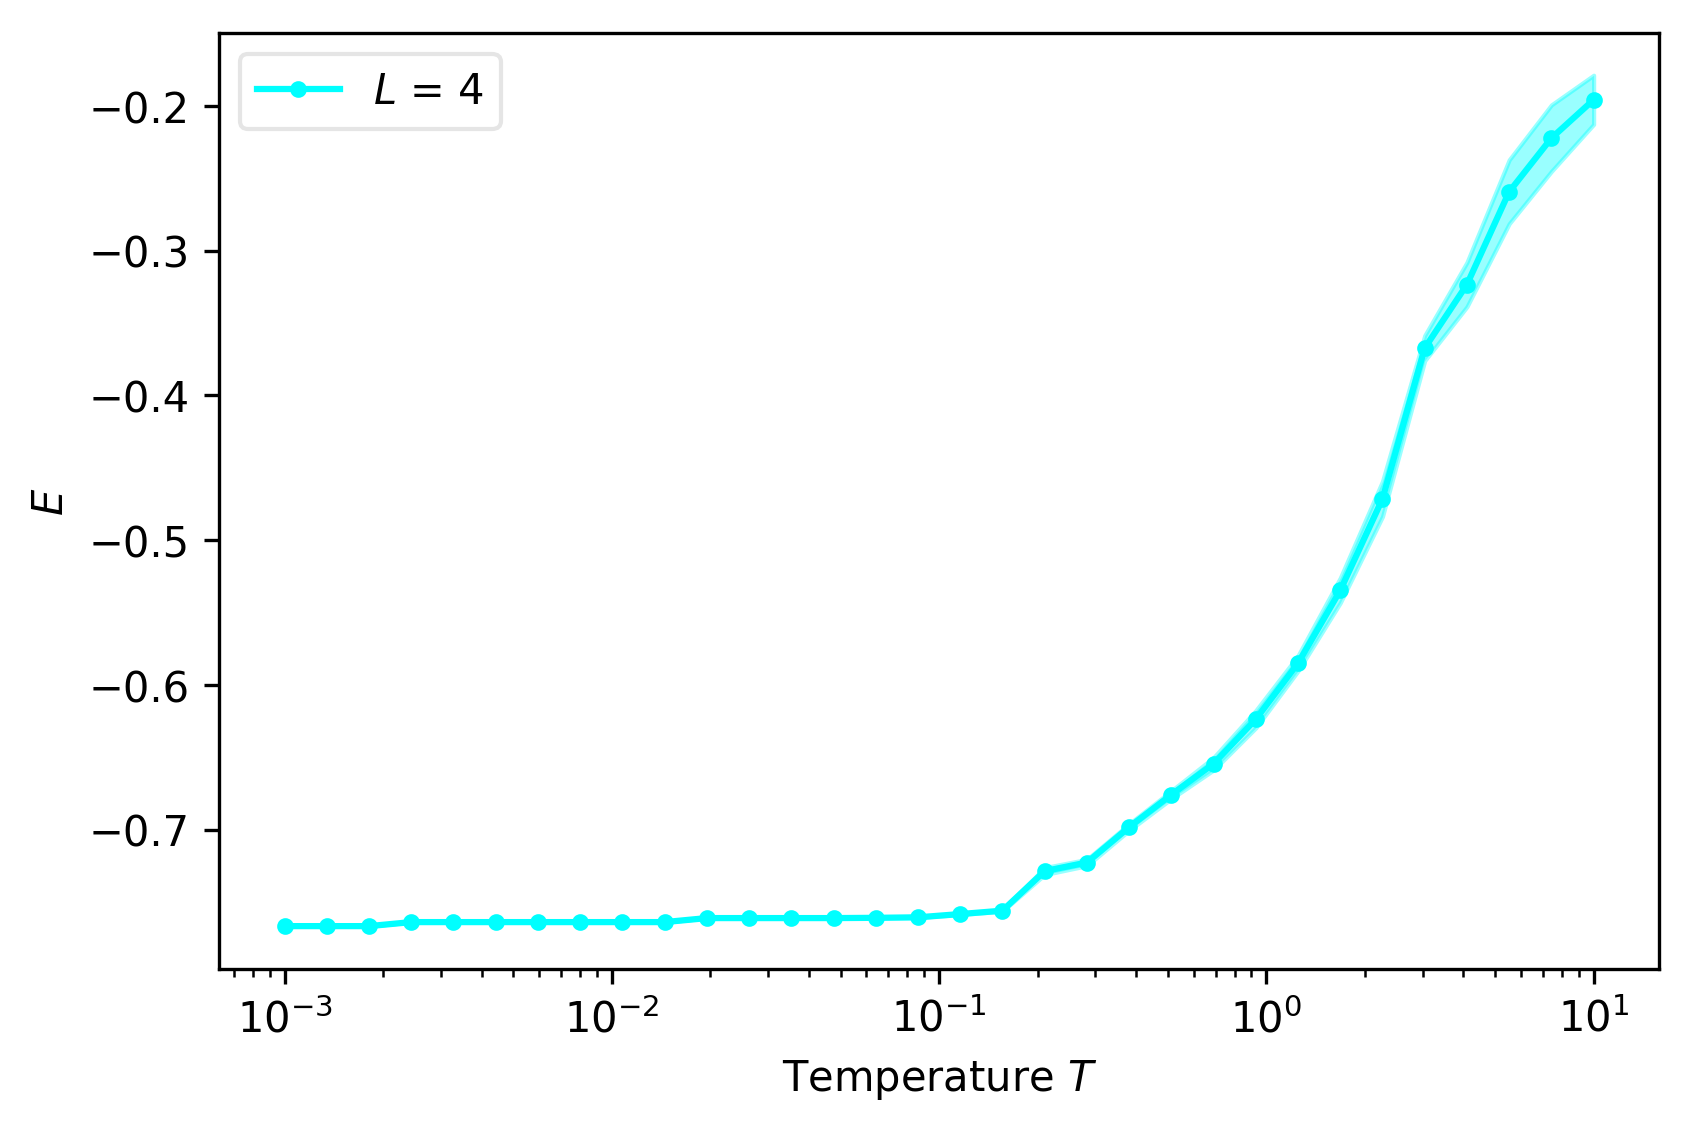

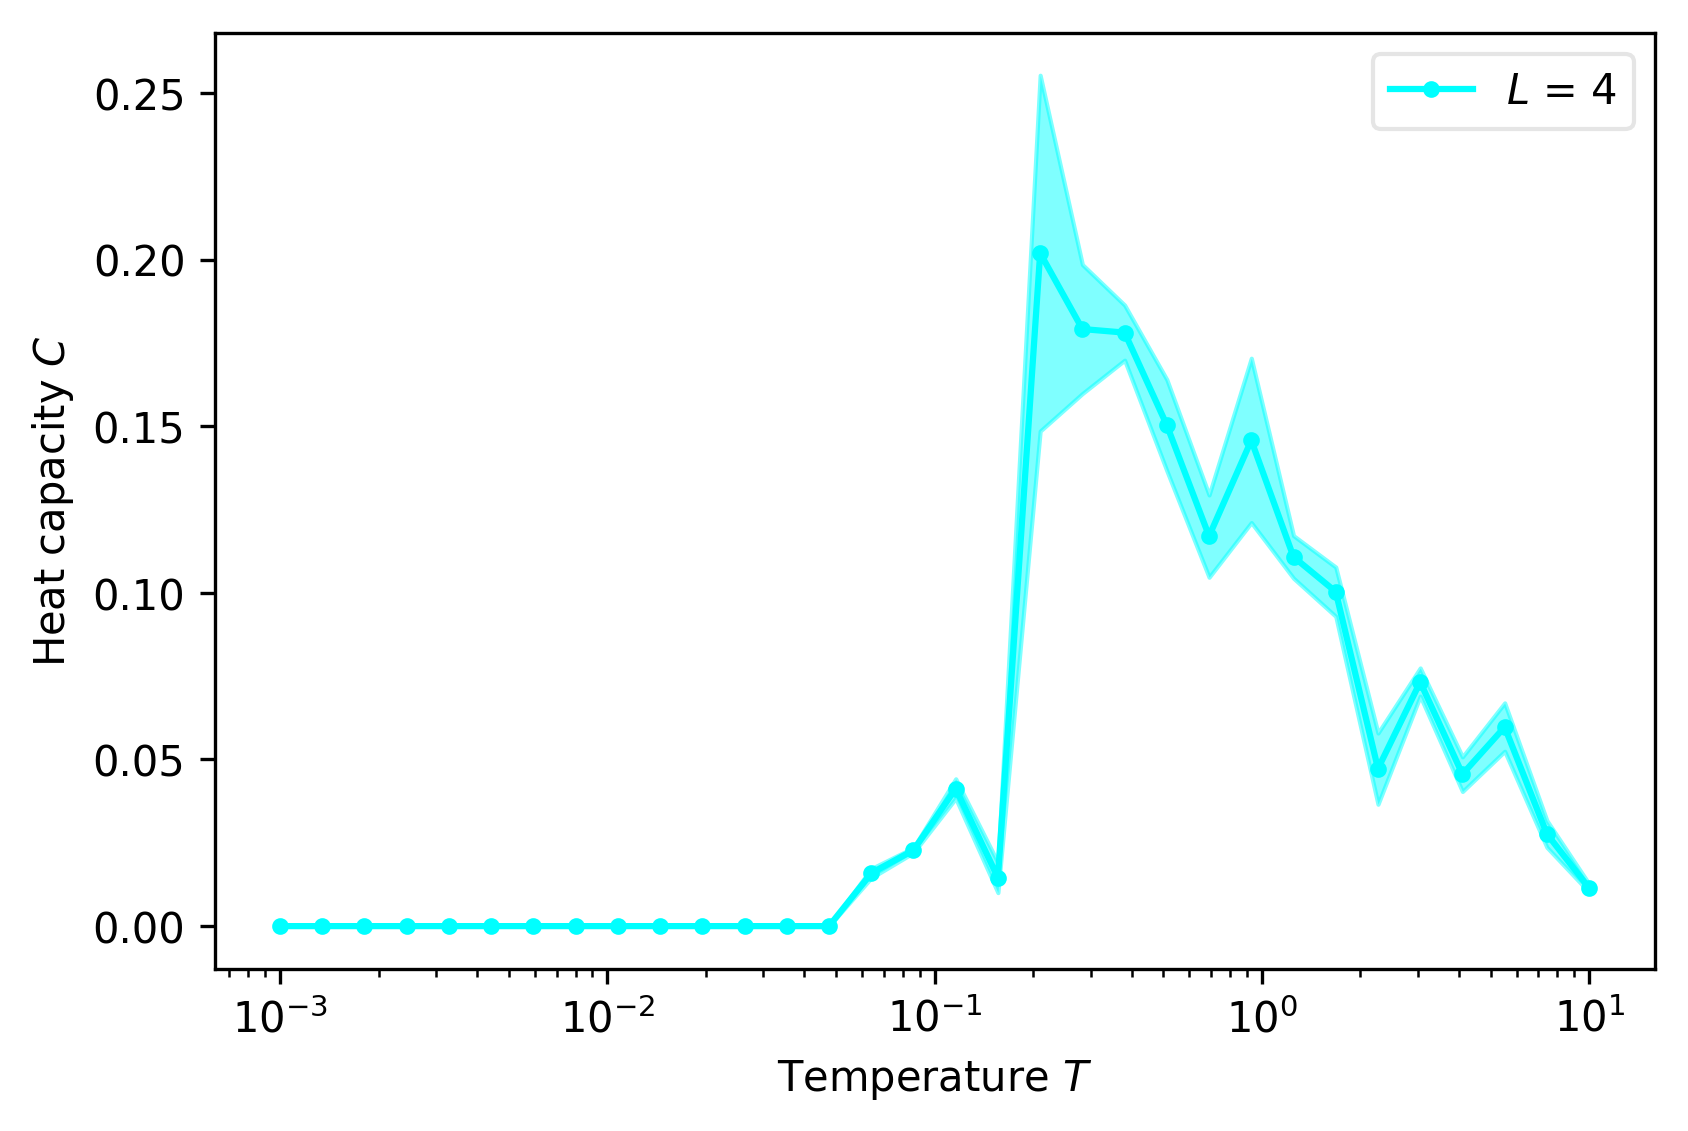

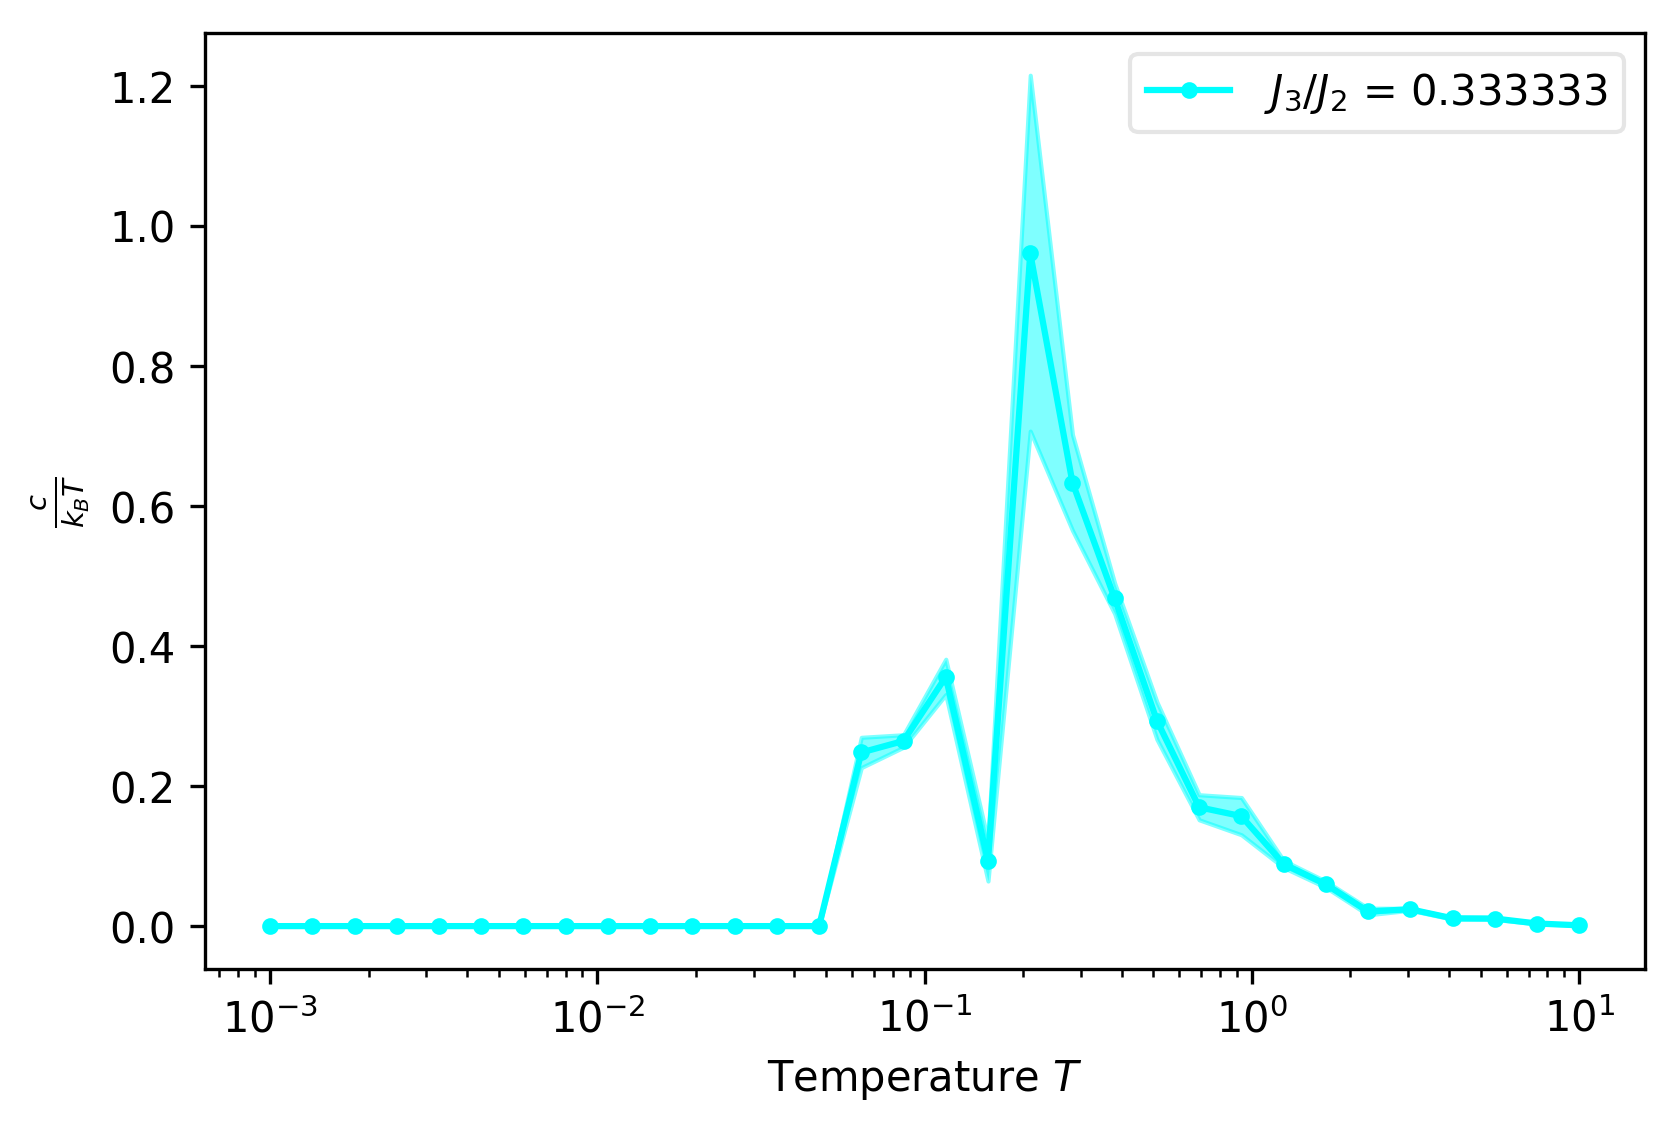

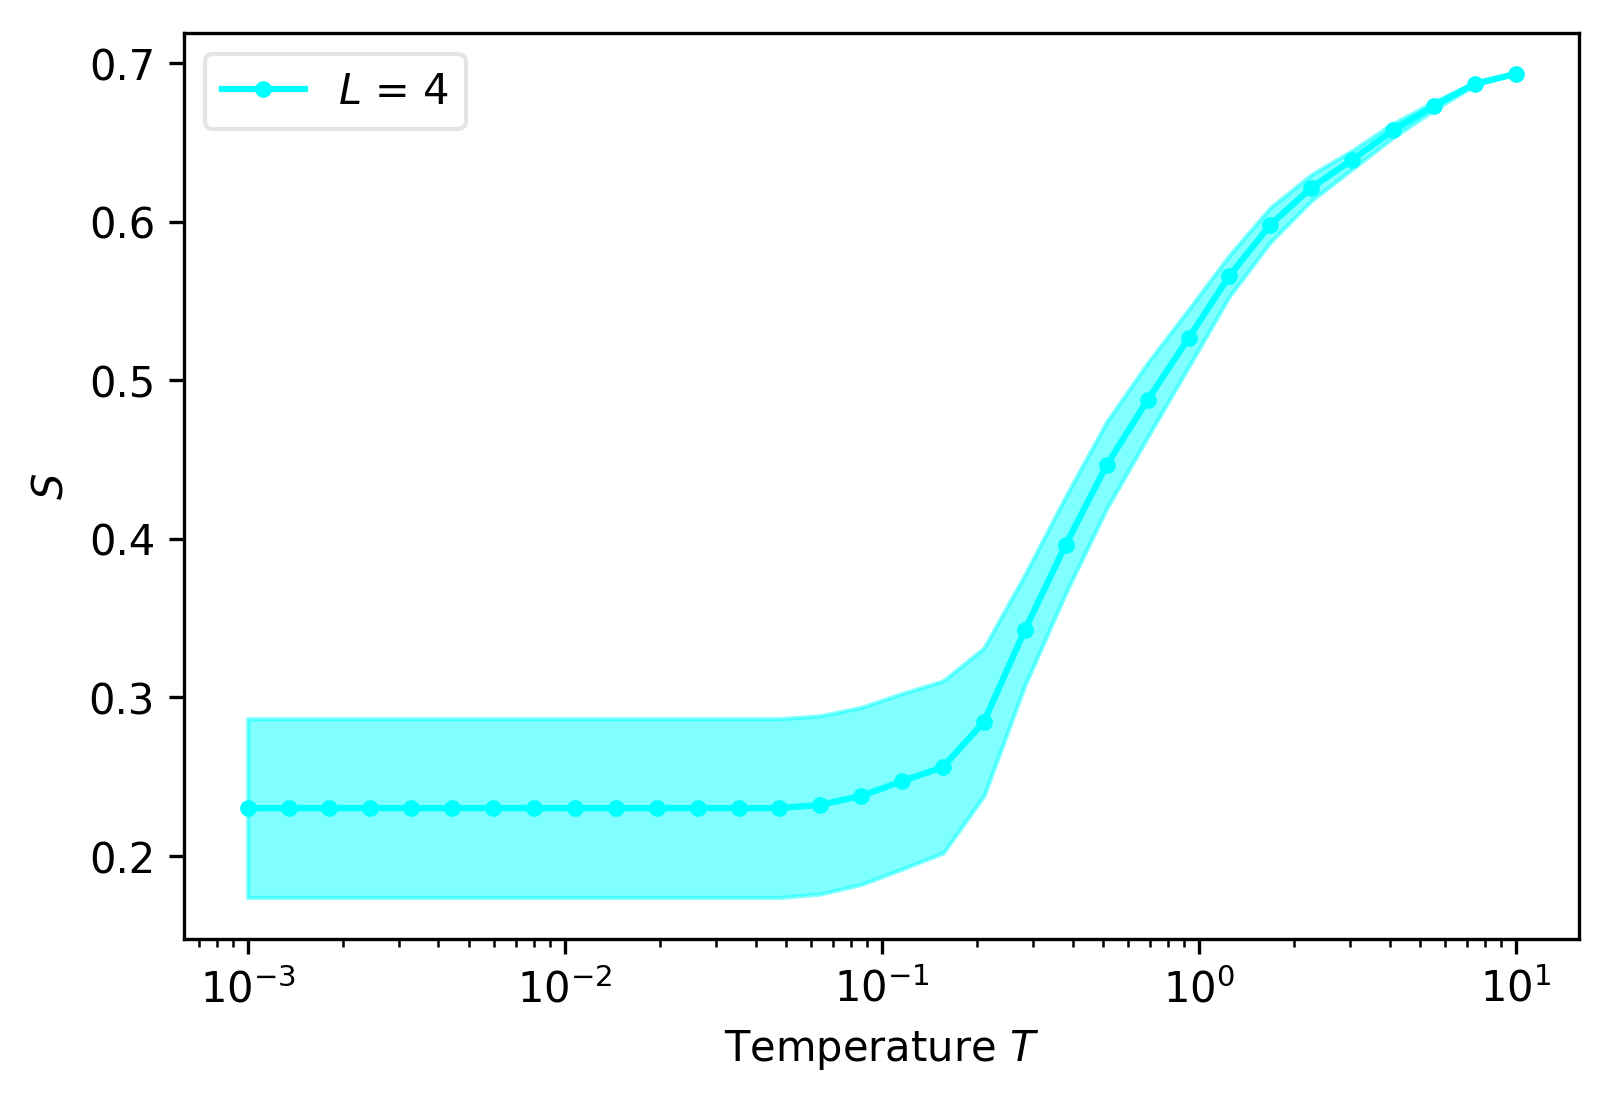

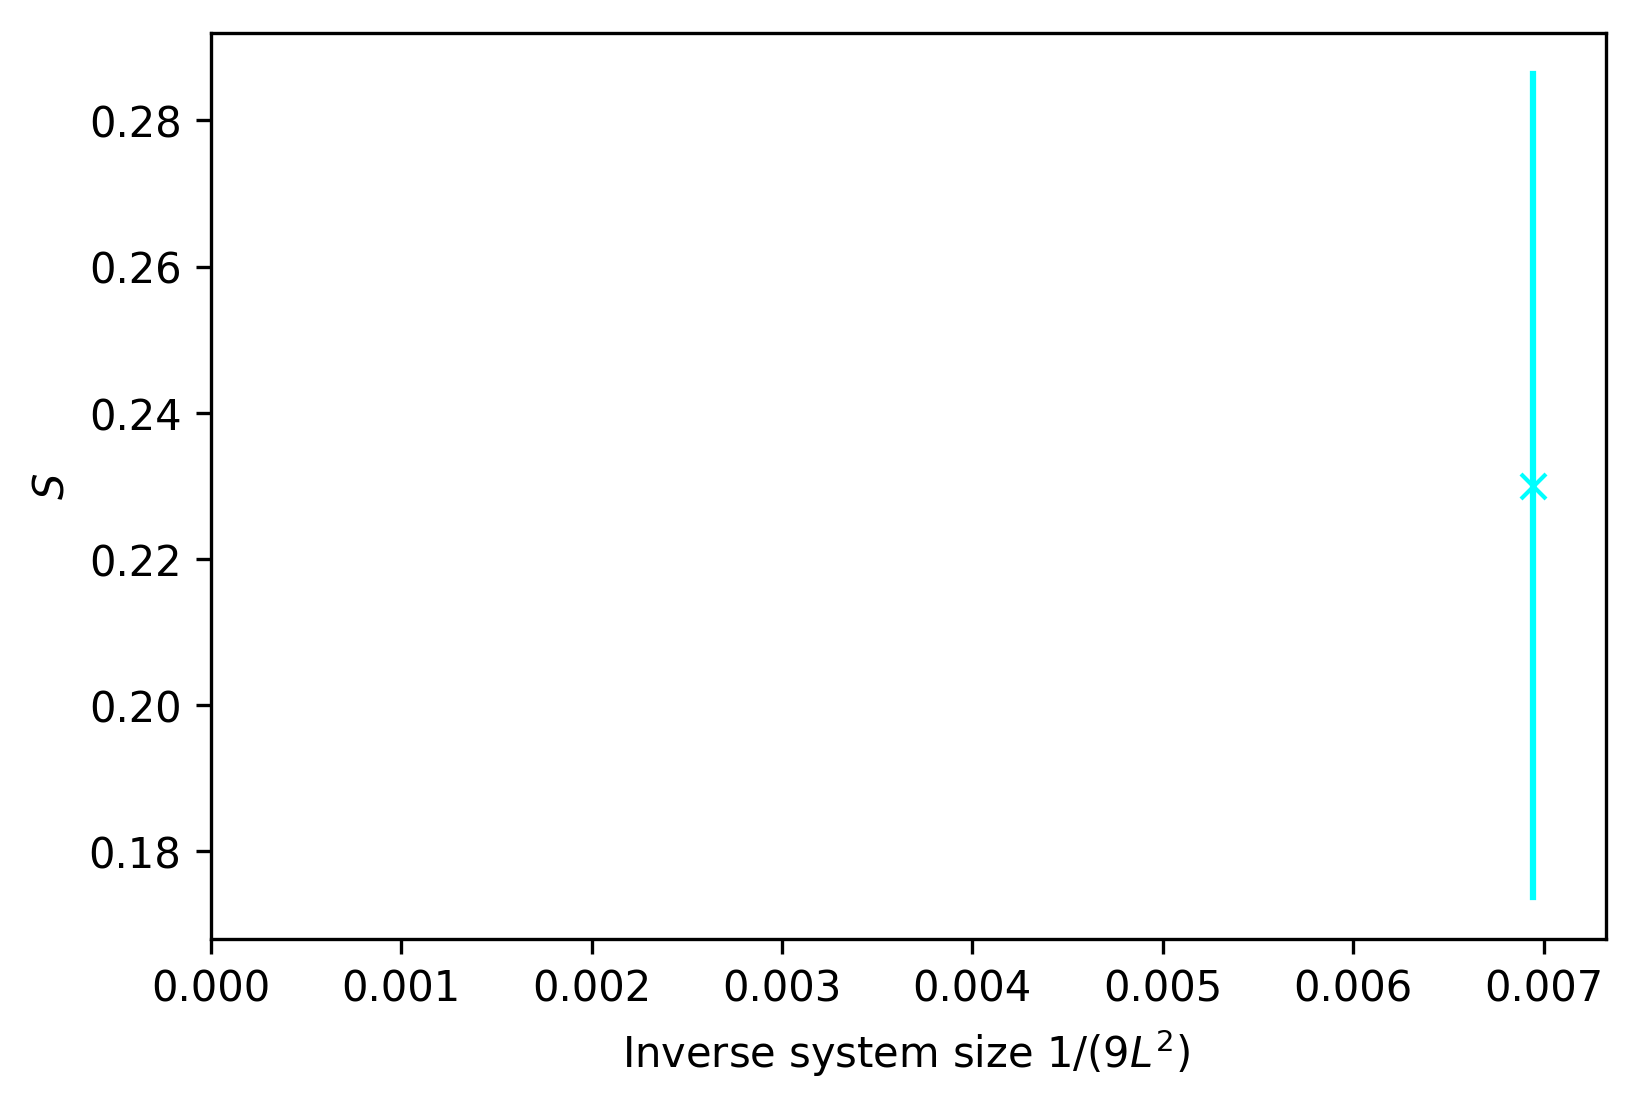

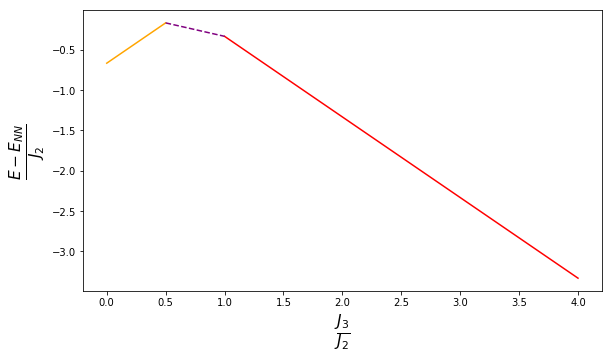

In [11]:
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, foldername, results_foldername, filenamelist, t_MeanE, t_MeanEsq, t_varMeanE, t_varMeanEsq, C, ErrC, J1, J2, J3, J4, S0)

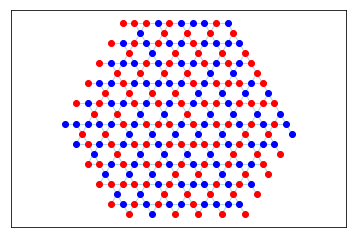

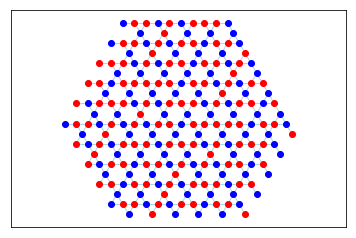

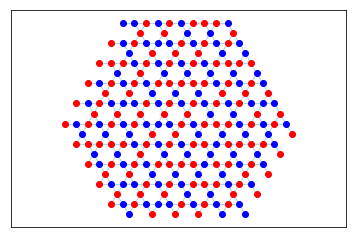

In [12]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_spinstates, t_states] = \
 af.LoadStates(foldername, filenamelist, numsites, nb,
               stat_temps, temperatures, listfunctions, **kw)
plt.figure()
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][0]), ijl_s, L[0], 2, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()
plt.figure()
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][1]), ijl_s, L[0], 2, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()
plt.figure()
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][10]), ijl_s, L[0], 2, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()


<Figure size 432x288 with 0 Axes>

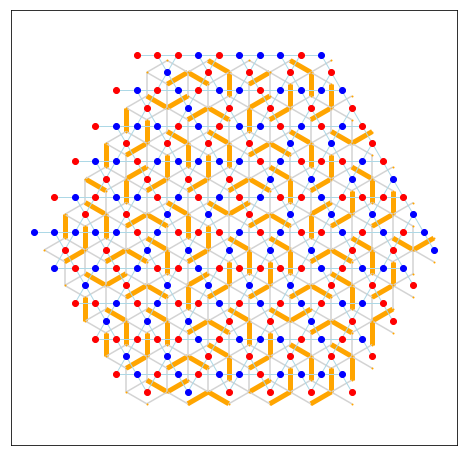

In [13]:
n = 0
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d,
 d_nd, d_vd, d_wn, sidlist, didlist,
 c_ijl, ijl_c, c2s, csign] = dw.latticeinit(L[n])

idstate = 0
plt.figure()
kdraw.plotstate(idstate, L[n], d_ijl, ijl_s, sidlist, didlist, s2_d,
               t_states[n], t_spinstates[n],dim_node_color = 'orange',
                dim_color = "orange", no_dim_color = 'lightgrey')
plt.savefig("./" + foldername + "/TestState{0}.png".format(idstate))
plt.show()